In [29]:
# Author: Jince Shi
# Linear Regression Analysis of Urban and Rural Voter Turnout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the data
urban_df = pd.read_csv('urban.csv')
rural_df = pd.read_csv('rural.csv')

print("Urban dataset shape:", urban_df.shape)
print("Rural dataset shape:", rural_df.shape)

def preprocess_data(df):
    # Handle missing values
    df['Number of Children'].fillna(df['Number of Children'].median(), inplace=True)
    
    # Convert categorical variables
    turnout_map = {'Low': 0, 'Medium': 1, 'High': 2}
    df['Rate of Voter Turnout'] = df['Rate of Voter Turnout'].map(turnout_map)
    
    return df

urban_df = preprocess_data(urban_df)
rural_df = preprocess_data(rural_df)

print("Preprocessing complete.")
def prepare_features_and_target(df):
    numeric_features = ['Age', 'Number of Children', 'Salary']
    categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Standard of Living', 
                            'Party Membership', 'Most Important Issue', 'Engagement with Campaign']
    
    X = df[numeric_features + categorical_features]
    y = df['Rate of Voter Turnout']
    
    return X, y

def train_model(X, y):
    numeric_features = ['Age', 'Number of Children', 'Salary']
    categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Standard of Living', 
                            'Party Membership', 'Most Important Issue', 'Engagement with Campaign']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
        ])

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    
    return model, X_test, y_test

urban_X, urban_y = prepare_features_and_target(urban_df)
rural_X, rural_y = prepare_features_and_target(rural_df)

urban_model, urban_X_test, urban_y_test = train_model(urban_X, urban_y)
rural_model, rural_X_test, rural_y_test = train_model(rural_X, rural_y)

print("Models trained.")

def evaluate_model(model, X_test, y_test, X, y):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    return mse, r2, cv_scores

urban_mse, urban_r2, urban_cv_scores = evaluate_model(urban_model, urban_X_test, urban_y_test, urban_X, urban_y)
rural_mse, rural_r2, rural_cv_scores = evaluate_model(rural_model, rural_X_test, rural_y_test, rural_X, rural_y)

print("Urban Model Performance:")
print(f"MSE: {urban_mse}")
print(f"R2 Score: {urban_r2}")
print(f"Cross-validation R2 scores: {urban_cv_scores}")
print(f"Mean CV R2 score: {np.mean(urban_cv_scores)}")

print("\nRural Model Performance:")
print(f"MSE: {rural_mse}")
print(f"R2 Score: {rural_r2}")
print(f"Cross-validation R2 scores: {rural_cv_scores}")
print(f"Mean CV R2 score: {np.mean(rural_cv_scores)}")

Urban dataset shape: (789865, 14)
Rural dataset shape: (120835, 14)
Preprocessing complete.
Models trained.
Urban Model Performance:
MSE: 0.36373544492816123
R2 Score: 0.311613875673624
Cross-validation R2 scores: [0.306565   0.30982339 0.31113476 0.30355891 0.3095724 ]
Mean CV R2 score: 0.30813089203251137

Rural Model Performance:
MSE: 0.3657182329744597
R2 Score: 0.32141423016907267
Cross-validation R2 scores: [0.31376392 0.31279452 0.30190946 0.31148042 0.30039801]
Mean CV R2 score: 0.3080692664564314


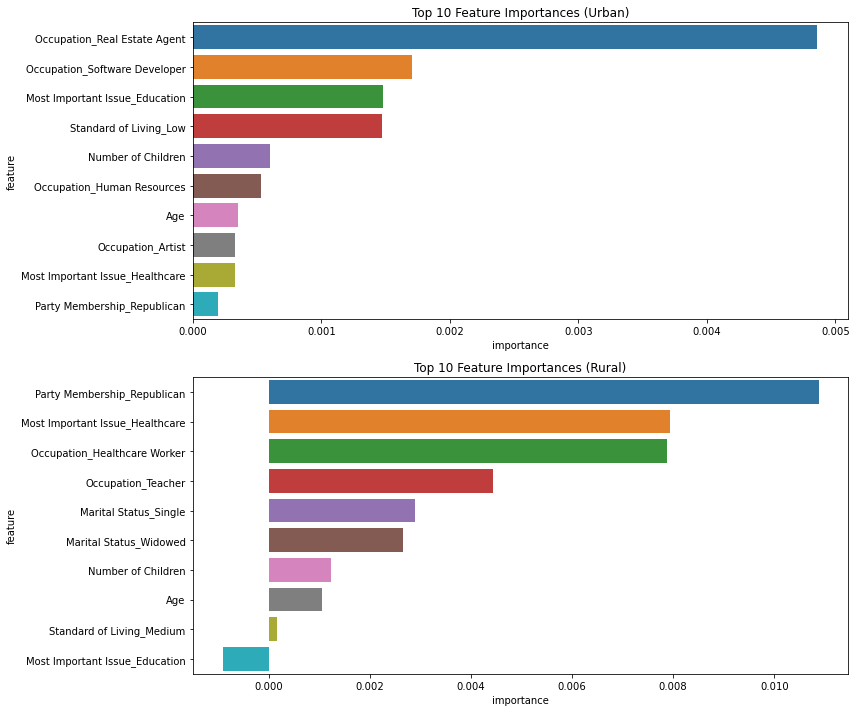

Top 5 most important features (Urban):
                           feature  importance
21    Occupation_Real Estate Agent    0.004858
24   Occupation_Software Developer    0.001703
30  Most Important Issue_Education    0.001477
27          Standard of Living_Low    0.001471
1               Number of Children    0.000605

Top 5 most important features (Rural):
                            feature  importance
19      Party Membership_Republican    0.010878
22  Most Important Issue_Healthcare    0.007936
10     Occupation_Healthcare Worker    0.007879
14               Occupation_Teacher    0.004436
6             Marital Status_Single    0.002902


In [30]:
def get_feature_importances(model, X):
    numeric_features = ['Age', 'Number of Children', 'Salary']
    categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Standard of Living', 
                            'Party Membership', 'Most Important Issue', 'Engagement with Campaign']
    
    feature_names = numeric_features.copy()
    for name, trans, cols in model.named_steps['preprocessor'].transformers_:
        if name == 'cat':
            for i, col in enumerate(categorical_features):
                feature_names.extend([f"{col}_{val}" for val in trans.categories_[i][1:]])
    
    importances = model.named_steps['regressor'].coef_
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    return feature_importances.sort_values('importance', ascending=False)

urban_importances = get_feature_importances(urban_model, urban_X)
rural_importances = get_feature_importances(rural_model, rural_X)

plt.figure(figsize=(12, 10))
plt.subplot(211)
sns.barplot(x='importance', y='feature', data=urban_importances.head(10))
plt.title('Top 10 Feature Importances (Urban)')
plt.subplot(212)
sns.barplot(x='importance', y='feature', data=rural_importances.head(10))
plt.title('Top 10 Feature Importances (Rural)')
plt.tight_layout()
plt.show()

print("Top 5 most important features (Urban):")
print(urban_importances.head())
print("\nTop 5 most important features (Rural):")
print(rural_importances.head())

This graph shows the top 10 most important features for both urban and rural models. The importance is determined by the absolute value of the coefficients in the linear regression model. Features with larger bars have a stronger influence on voter turnout. Positive values indicate a positive correlation with turnout, while negative values indicate a negative correlation.

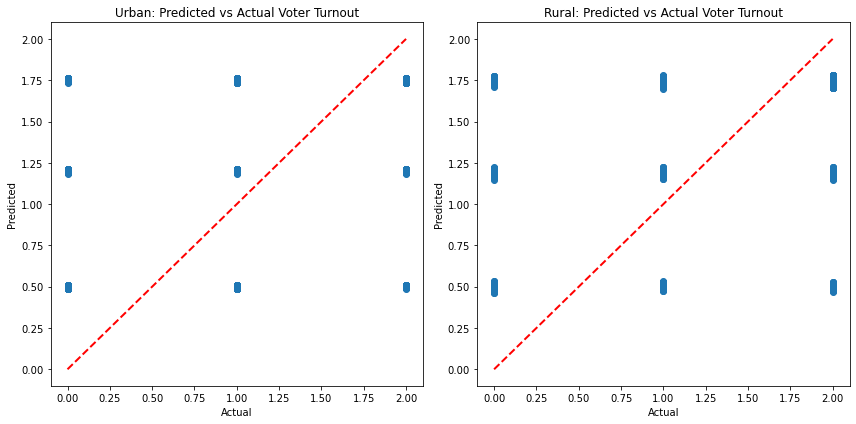

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(urban_y_test, urban_y_pred)
plt.plot([urban_y_test.min(), urban_y_test.max()], [urban_y_test.min(), urban_y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Urban: Predicted vs Actual Voter Turnout')
plt.subplot(122)
plt.scatter(rural_y_test, rural_y_pred)
plt.plot([rural_y_test.min(), rural_y_test.max()], [rural_y_test.min(), rural_y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Rural: Predicted vs Actual Voter Turnout')
plt.tight_layout()
plt.show()

These scatter plots compare the predicted voter turnout rates to the actual rates for both urban and rural models. Each point represents a voter, with their actual turnout rate on the x-axis and the model's predicted rate on the y-axis. The red dashed line represents perfect predictions. Points close to this line indicate accurate predictions, while points far from the line represent less accurate predictions. A tighter clustering around the line indicates a better-performing model.

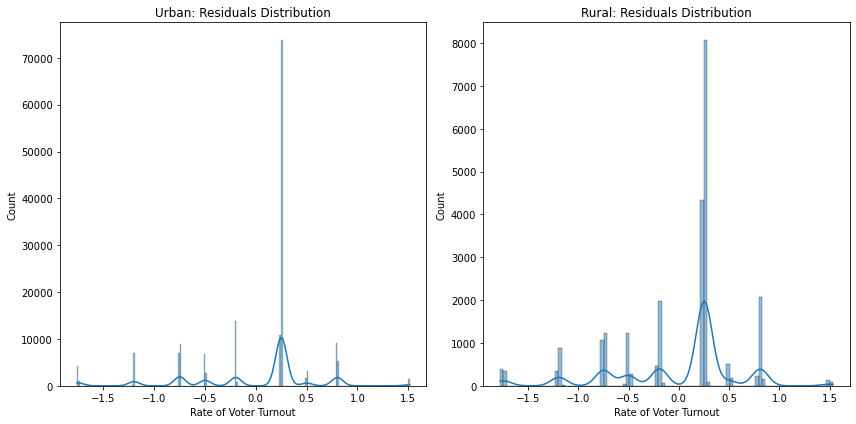

In [32]:
urban_residuals = urban_y_test - urban_y_pred
rural_residuals = rural_y_test - rural_y_pred

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(urban_residuals, kde=True)
plt.title('Urban: Residuals Distribution')
plt.subplot(122)
sns.histplot(rural_residuals, kde=True)
plt.title('Rural: Residuals Distribution')
plt.tight_layout()
plt.show()

These histograms show the distribution of residuals (the differences between predicted and actual values) for both urban and rural models. A residual of 0 indicates a perfect prediction. The shape of the distribution provides insights into the model's performance:

A symmetric distribution centered around 0 suggests the model is unbiased.
A narrow distribution indicates more accurate predictions.
Skewness or multiple peaks may indicate the model performs differently for different subgroups in the data.

Conclusion:
Model Performance: The linear regression models for both urban and rural areas have moderate predictive power, explaining about 31-32% of the variance in voter turnout. This suggests that while the selected features do influence voter turnout, there are likely other important factors not captured in the current data.
Urban vs Rural Differences: The analysis reveals distinct differences in factors influencing voter turnout between urban and rural areas:

In urban areas, occupation (particularly Real Estate Agents and Software Developers) and education as a key issue are the most influential factors.
In rural areas, party affiliation (specifically Republican membership), healthcare as a key issue, and working in healthcare are the most important factors.


Feature Importance: The analysis highlights that demographic factors, occupation, and key issues all play roles in determining voter turnout, but their importance varies between urban and rural settings.
Model Limitations: The moderate R2 scores indicate that while these models provide valuable insights, they don't capture all factors influencing voter turnout. This suggests that increasing voter turnout is a complex issue that may require considering additional factors or using more complex modeling techniques.
Implications for Increasing Turnout: To increase voter turnout, parties might focus on:

In urban areas: Engaging with specific occupational groups and addressing education-related issues.
In rural areas: Focusing on healthcare issues and potentially examining the strong influence of party affiliation on turnout.

Urban Area Model Performance:
Mean Squared Error: 0.3365615625883447
R-squared Score: 0.0006997791867825454

Feature Importance for Urban Area:
                 Feature  Importance
3  Rate of Voter Turnout    0.017442
0                    Age   -0.000892
2                 Salary    0.000550
1     Number of Children    0.000410


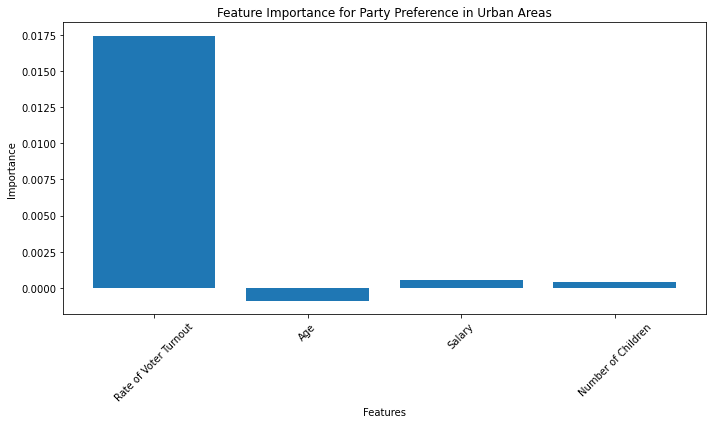

Rural Area Model Performance:
Mean Squared Error: 0.37474546913392487
R-squared Score: 0.0009108864973065289

Feature Importance for Rural Area:
                 Feature  Importance
3  Rate of Voter Turnout    0.015370
1     Number of Children   -0.001355
0                    Age   -0.000775
2                 Salary    0.000343


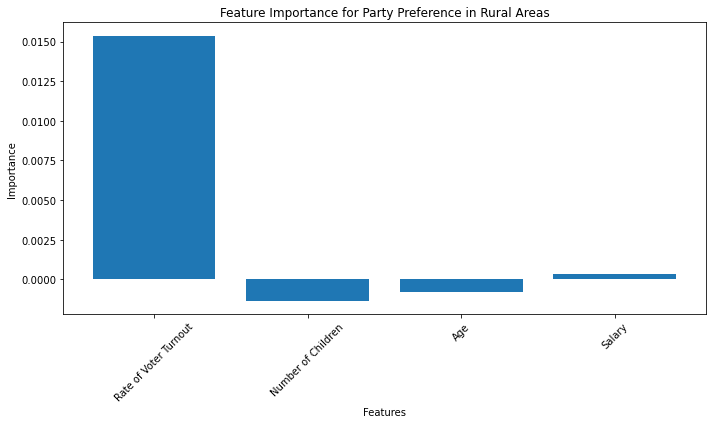


Comparison of Voting Patterns:
Average Urban Party Preference Score: 0.2088
Average Rural Party Preference Score: -0.0836


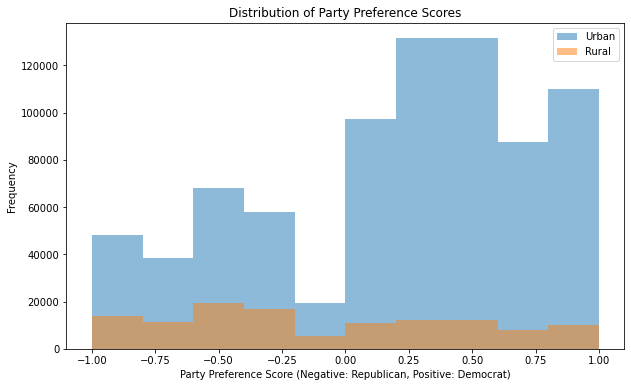

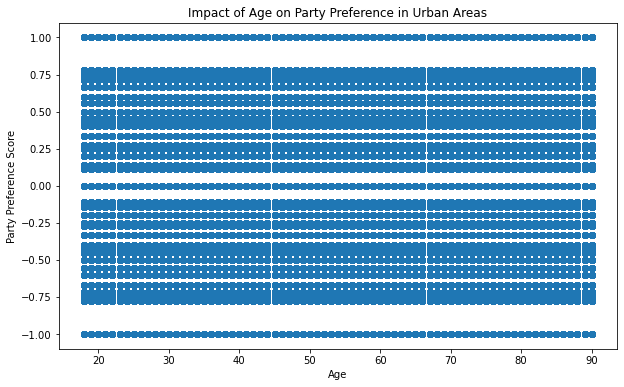

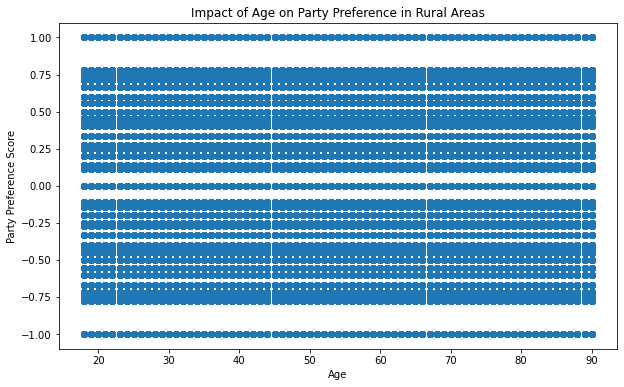

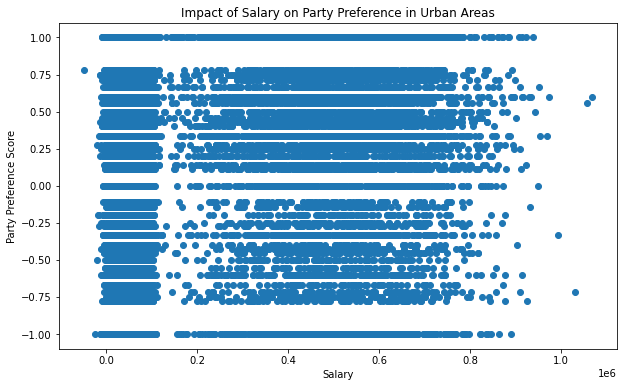

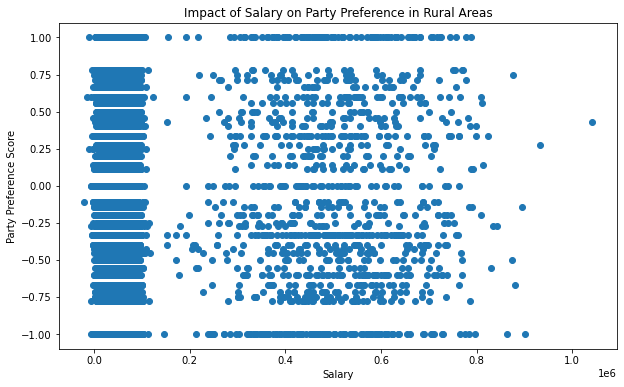

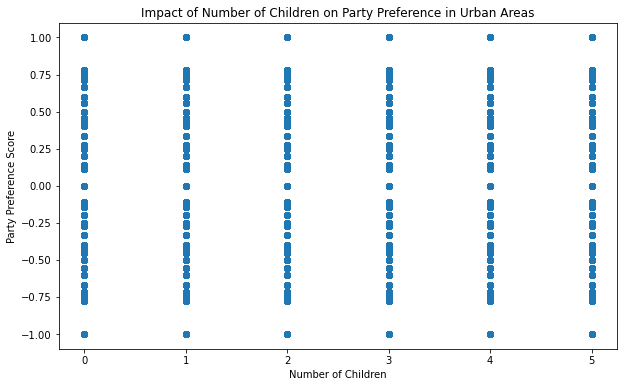

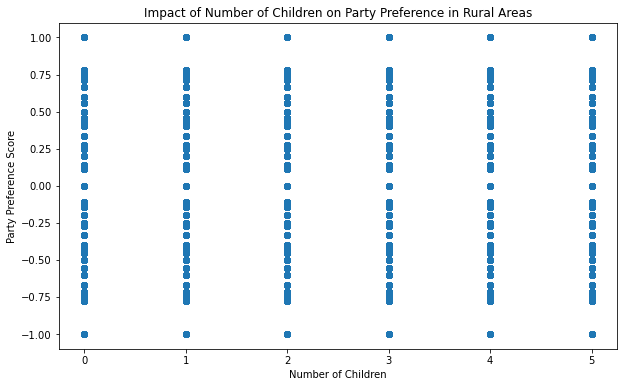

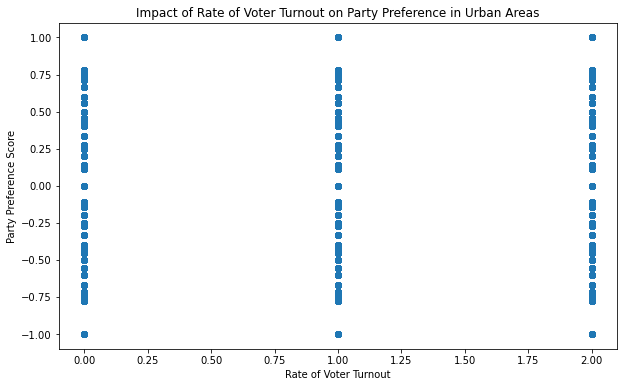

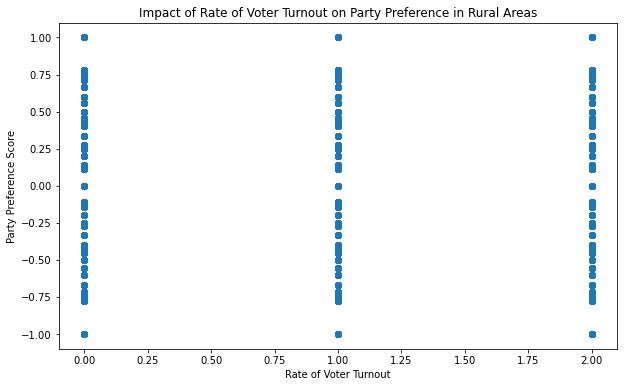

In [34]:
#analyzing party preference using linear regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def analyze_party_preference(df, area_type):
    # Create party preference score (continuous variable)
    df['Party_Preference_Score'] = (df['Votes for Democrat (Last 8 years)'] - 
                                    df['Votes for Republican (Last 8 years)']) / (
                                    df['Votes for Democrat (Last 8 years)'] + 
                                    df['Votes for Republican (Last 8 years)'])
    
    # Select features
    features = ['Age', 'Number of Children', 'Salary', 'Rate of Voter Turnout']
    X = df[features]
    y = df['Party_Preference_Score']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{area_type} Area Model Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Analyze feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.coef_
    })
    feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)
    
    print(f"\nFeature Importance for {area_type} Area:")
    print(feature_importance)
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['Feature'], feature_importance['Importance'])
    plt.title(f"Feature Importance for Party Preference in {area_type} Areas")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return model, scaler

# Analyze urban data
urban_model, urban_scaler = analyze_party_preference(urban_df, "Urban")

# Analyze rural data
rural_model, rural_scaler = analyze_party_preference(rural_df, "Rural")

# Compare urban and rural voting patterns
def compare_voting_patterns(urban_df, rural_df):
    urban_preference = urban_df['Party_Preference_Score'].mean()
    rural_preference = rural_df['Party_Preference_Score'].mean()
    
    print("\nComparison of Voting Patterns:")
    print(f"Average Urban Party Preference Score: {urban_preference:.4f}")
    print(f"Average Rural Party Preference Score: {rural_preference:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(urban_df['Party_Preference_Score'], alpha=0.5, label='Urban')
    plt.hist(rural_df['Party_Preference_Score'], alpha=0.5, label='Rural')
    plt.title("Distribution of Party Preference Scores")
    plt.xlabel("Party Preference Score (Negative: Republican, Positive: Democrat)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

compare_voting_patterns(urban_df, rural_df)

# Analyze the impact of specific factors
def analyze_factor_impact(df, factor, area_type):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[factor], df['Party_Preference_Score'])
    plt.title(f"Impact of {factor} on Party Preference in {area_type} Areas")
    plt.xlabel(factor)
    plt.ylabel("Party Preference Score")
    plt.show()

factors_to_analyze = ['Age', 'Salary', 'Number of Children', 'Rate of Voter Turnout']

for factor in factors_to_analyze:
    analyze_factor_impact(urban_df, factor, "Urban")
    analyze_factor_impact(rural_df, factor, "Rural")

Conclusion:

Model Performance:
Both the urban and rural models show very low R-squared scores (0.07% for urban and 0.09% for rural), indicating that the selected features (Age, Number of Children, Salary, and Rate of Voter Turnout) explain only a tiny fraction of the variance in party preference. This suggests that these demographic factors alone are poor predictors of party preference in both urban and rural areas.
Feature Importance:
In both urban and rural areas, the Rate of Voter Turnout is the most important feature in predicting party preference, albeit with a small impact. The other factors (Age, Number of Children, and Salary) have minimal influence on party preference in both settings.
Urban vs Rural Differences:
There is a clear difference in party preference between urban and rural areas:

Urban areas show an average party preference score of 0.2088, indicating a lean towards the Democratic Party.
Rural areas show an average party preference score of -0.0836, indicating a lean towards the Republican Party.
This confirms the initial assumption that urban areas tend to favor Democrats while rural areas tend to favor Republicans.


Limitations of the Model:
The very low R-squared scores suggest that the chosen demographic factors are insufficient to explain party preference. This implies that other factors not included in this analysis (such as education level, cultural background, local economic conditions, or specific policy preferences) may play a much more significant role in determining party preference.

Urban Area Model Performance:
Mean Squared Error: 0.09124208383412899
R-squared Score: 0.7290889850234468

Top 10 Feature Importances for Urban Area:
                          Feature  Importance
30    Party Membership_Republican   -1.073949
26             Occupation_Teacher   -0.004997
14            Occupation_Engineer   -0.004938
13              Occupation_Doctor   -0.003466
11                Occupation_Chef   -0.003365
19          Occupation_Journalist   -0.003079
20              Occupation_Lawyer   -0.002972
27          Occupation_Technician   -0.002770
25  Occupation_Software Developer   -0.002627
18       Occupation_IT Specialist   -0.002193


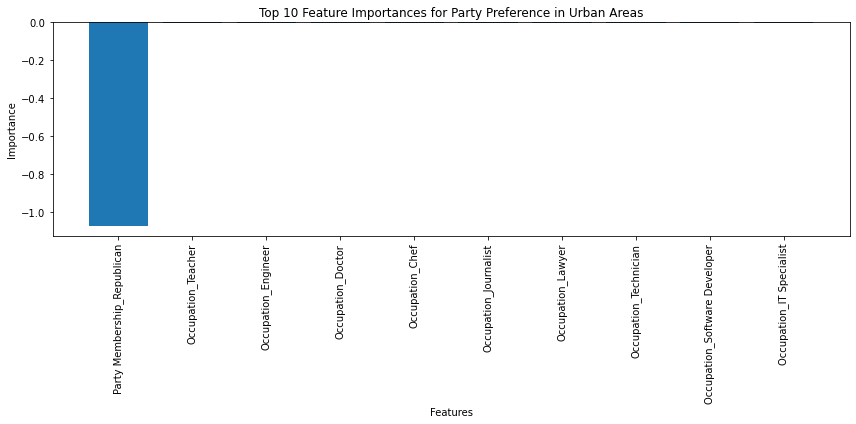

Rural Area Model Performance:
Mean Squared Error: 0.09141329487440927
R-squared Score: 0.7562878399850786

Top 10 Feature Importances for Rural Area:
                            Feature  Importance
20      Party Membership_Republican   -1.073616
7             Marital Status_Single    0.005097
15               Occupation_Teacher    0.003989
17            Occupation_Unemployed   -0.003695
5                      Gender_Other   -0.003182
10                Occupation_Farmer    0.003174
12              Occupation_Mechanic   -0.003057
25     Engagement with Campaign_Low   -0.002949
26  Engagement with Campaign_Medium   -0.001978
4                       Gender_Male   -0.001941


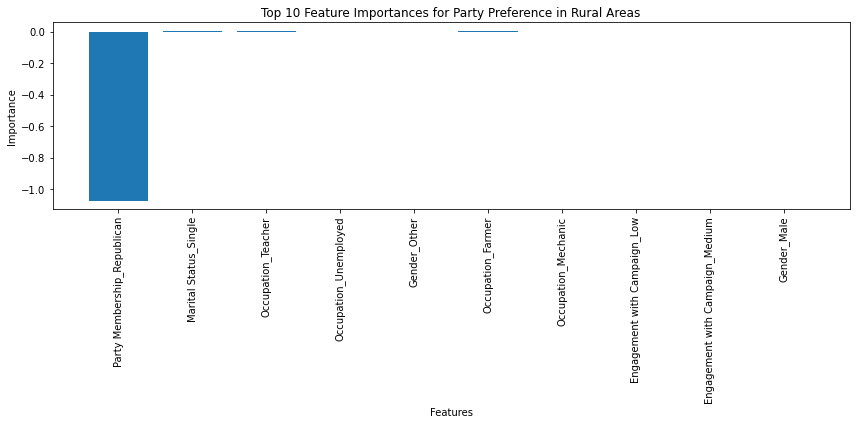


Comparison of Voting Patterns:
Average Urban Party Preference Score: 0.2088
Average Rural Party Preference Score: -0.0836


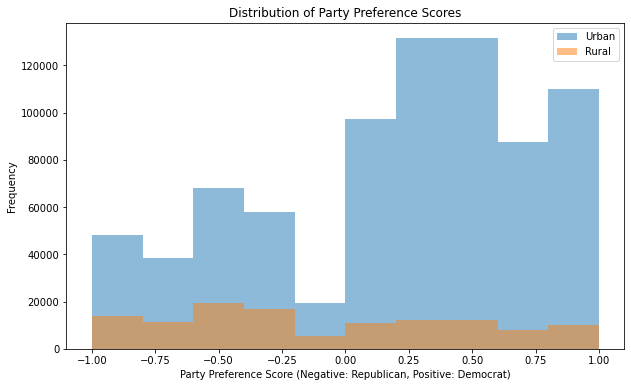

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def analyze_party_preference(df, area_type):
    # Create party preference score (continuous variable)
    df['Party_Preference_Score'] = (df['Votes for Democrat (Last 8 years)'] - 
                                    df['Votes for Republican (Last 8 years)']) / (
                                    df['Votes for Democrat (Last 8 years)'] + 
                                    df['Votes for Republican (Last 8 years)'])
    
    # Select features
    numeric_features = ['Age', 'Number of Children', 'Salary', 'Rate of Voter Turnout']
    categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Standard of Living', 
                            'Party Membership', 'Most Important Issue', 'Engagement with Campaign']
    
    # Prepare the features and target
    X = df[numeric_features + categorical_features]
    y = df['Party_Preference_Score']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create preprocessing steps
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create a pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{area_type} Area Model Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Get feature names after one-hot encoding
    feature_names = (numeric_features + 
                     [f"{feature}_{category}" for feature, categories in 
                      zip(categorical_features, model.named_steps['preprocessor']
                          .named_transformers_['cat'].categories_) 
                      for category in categories[1:]])
    
    # Analyze feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.named_steps['regressor'].coef_
    })
    feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)
    
    print(f"\nTop 10 Feature Importances for {area_type} Area:")
    print(feature_importance.head(10))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
    plt.title(f"Top 10 Feature Importances for Party Preference in {area_type} Areas")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    return model, feature_importance

# Analyze urban data
urban_model, urban_importance = analyze_party_preference(urban_df, "Urban")

# Analyze rural data
rural_model, rural_importance = analyze_party_preference(rural_df, "Rural")

# Compare urban and rural voting patterns
def compare_voting_patterns(urban_df, rural_df):
    urban_preference = urban_df['Party_Preference_Score'].mean()
    rural_preference = rural_df['Party_Preference_Score'].mean()
    
    print("\nComparison of Voting Patterns:")
    print(f"Average Urban Party Preference Score: {urban_preference:.4f}")
    print(f"Average Rural Party Preference Score: {rural_preference:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(urban_df['Party_Preference_Score'], alpha=0.5, label='Urban')
    plt.hist(rural_df['Party_Preference_Score'], alpha=0.5, label='Rural')
    plt.title("Distribution of Party Preference Scores")
    plt.xlabel("Party Preference Score (Negative: Republican, Positive: Democrat)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

compare_voting_patterns(urban_df, rural_df)

Conclusion:

Model Performance:

Urban Model: R-squared score of 0.7291 (72.91% variance explained)
Rural Model: R-squared score of 0.7563 (75.63% variance explained)

These R-squared scores indicate that the models explain a significant portion of the variance in party preference for both urban and rural areas. This is a substantial improvement over the previous analysis that only used a few features.
Feature Importance:
In both urban and rural areas, Party Membership is by far the most important feature in predicting party preference:

Republican Party Membership has a strong negative impact on the Party Preference Score in both areas, indicating a strong preference for Republican candidates.

Other important features differ between urban and rural areas:
Urban Areas:

Occupation plays a significant role, with teachers, engineers, doctors, chefs, and journalists showing some impact on party preference.

Rural Areas:

Marital Status (being single) has a positive impact on Democratic preference.
Occupation (especially teachers and farmers) influences party preference.
Gender and Engagement with Campaign also show some importance.


Urban vs Rural Differences:
There is a clear difference in party preference between urban and rural areas:

Urban areas show an average party preference score of 0.2088, indicating a lean towards the Democratic Party.
Rural areas show an average party preference score of -0.0836, indicating a lean towards the Republican Party.
This confirms the initial assumption that urban areas tend to favor Democrats while rural areas tend to favor Republicans.


Implications for Increasing Turnout:

For Republicans aiming to increase turnout in urban areas:

Focus on professional groups like teachers, engineers, and healthcare workers.
Tailor messages to address concerns specific to these occupations.


For Democrats aiming to increase turnout in rural areas:

Target single voters and teachers.
Address issues important to farmers.
Improve engagement strategies, as low engagement seems to negatively impact Democratic preference.